# Introduction to `kgof`

This notebook will introduce you to  `kgof` (kernel goodness-of-fit), a Python package implementing a linear-time kernel-based goodness-of-fit test as described in 

    A Linear-Time Kernel Goodness-of-Fit Test
    Wittawat Jitkrittum, Wenkai Xu, Zoltan Szabo, Kenji Fukumizu, Arthur Gretton
    NIPS 2017
    https://arxiv.org/abs/1705.07673

See the [Github page](https://github.com/wittawatj/kernel-gof) for more information. 

Make sure that you have `kgof` included in Python's search path. In particular the following import statements should not produce any fatal error.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

In `kgof`, we use [`autograd`](https://github.com/HIPS/autograd) to compute derivatives for our optimization problem. So instead of 

    import numpy as np

make sure you use 

    import autograd.numpy as np

## Goodness-of-fit test

Given a known probability density $p$ (model) and a sample $\{ \mathbf{x}_i \}_{i=1}^n \sim q$ where $q$ is an unknown density, a goodness-of-fit test proposes a null hypothesis

$H_0: p = q$

against the alternative hypothesis

$H_1: p \neq q$. 

In other words, it tests whether or not the sample $\{ \mathbf{x}_i \}_{i=1}^n $ is distributed according to a known  $p$.

Our test relies on a new test statistic called **The Finite-Set Stein Discrepancy (FSSD)** which is a discrepancy measure between a density and a sample. Unique features of our new goodness-of-fit test are

1. It makes only a few mild assumptions on the distributions $p$ and $q$. The model $p$ can take almost any form. The normalizer of $p$ is not assumed known. The test only assesses the goodness of $p$ through $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ i.e., the first derivative of the log density.

2. The runtime complexity of the full procedure (both parameter tuning and the actual test) is $\mathcal{O}(n)$ i.e., linear in the sample size. 

3. It returns a set of points (**features**) which indicate where $p$ fails to fit the data.

For demonstration purpose, let us consider a simple two-dimensional toy problem where $p$ is the standard Gaussian.

### A simple Gaussian model

Let us assume that $p(\mathbf{x}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$ in $\mathbb{R}^2$ (two-dimensional space). The data $\{ \mathbf{x}_i \}_{i=1}^n \sim q = \mathcal{N}([m, 0], \mathbf{I})$ where $m$ specifies the mean of the first coordinate of $q$. From this setting, if $m\neq 0$, then $H_1$ is true and the test should reject $H_0$. 

Let us first construct the log density function for our model.

In [2]:
# Assume two dimensions.
d = 2
def isogauss_log_den(X):
    """
    Evaluate the log density at the points (rows) in X 
    of the standard isotropic Gaussian.
    Note that the density is NOT normalized. 
    
    X: n x d nd-array
    return a length-n array
    """
    mean = np.zeros(d)
    variance = 1
    unden = -np.sum((X-mean)**2, 1)/(2.0*variance)
    return unden

Notice that the function computes the log of an **unnormalized** density. This works fine as our test only requires $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ which does not depend on the normalizer. The gradient $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ will be automatically computed by `autograd`.

In `kgof` package, a model $p$ can be specified by implementing the class `density.UnnormalizedDensity`. Implementing this directly is a bit tedious, however. An easier way is to use the function 

    density.from_log_den(d, f) 
    
which takes as input 2 arguments:

1. `d`: the dimension of the input space
2. `f`: a function taking in a 2D numpy array of size `n x d` and producing a one-dimensional array of size `n` for the `n` values of the log unnormalized density.



Let us construct an `UnnormalizedDensity` which is the object representing a model. All the implemented goodness-of-fit tests take this object as an input.

In [3]:
# p is an UnnormalizedDensity object
p = density.from_log_den(d, isogauss_log_den)

Next, let us draw some sample from $q$.

In [4]:
# Let's assume that m = 1.

# If m=0, then p=q and H_0 is true.
# m = 0
m = 1

# Draw n points from q
seed = 4
np.random.seed(seed)
n = 400
X = np.random.randn(n, 2) + np.array([m, 0])

Plot the data from q

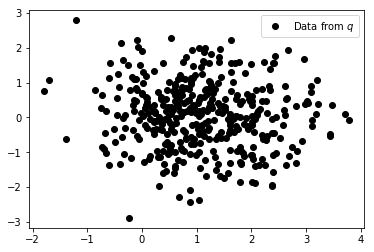

In [5]:
plt.plot(X[:, 0], X[:, 1], 'ko', label='Data from $q$')
plt.legend()

All the implemented tests take the data in the form of a `data.Data` object. This is just an encapsulation of the sample `X`. To construct `data.Data` we do the following

In [6]:
# dat will be fed to the test.
dat = data.Data(X)

----------

Now that we have the data, let us randomly split it into two disjoint halves: `tr` and `te`. The training set `tr` will be used for parameter optimization. The testing set `te` will be used for the actual goodness-of-fit test. `tr` and `te` are again of type `data.Data`.

In [7]:
# We will use 20% of the data for parameter tuning, and 80% for testing.
tr, te = dat.split_tr_te(tr_proportion=0.2, seed=2)

Let us optimize the parameters of the test on `tr`. The optimization relies on `autograd` to compute the gradient. We will use a Gaussian kernel for the test.

In [8]:
# J is the number of test locations (or features). Typically not larger than 10.
J = 1

# There are many options for the optimization. 
# Almost all of them have default values. 
# Here, we will list a few to give you a sense of what you can control.
# Full options can be found in gof.GaussFSSD.optimize_locs_widths(..)
opts = {
    'reg': 1e-2, # regularization parameter in the optimization objective
    'max_iter': 50, # maximum number of gradient ascent iterations
    'tol_fun':1e-7, # termination tolerance of the objective
}

# make sure to give tr (NOT te).
# do the optimization with the options in opts.
V_opt, gw_opt, opt_info = gof.GaussFSSD.optimize_auto_init(p, tr, J, **opts)

The optimization procedure returns back 

1. `V_opt`: optimized test locations (features). A $J \times d$ numpy array.
2. `gw_opt`: optimized Gaussian width (for the Gaussian kernel). A floating point number.
3. `opt_info`: a dictionary containing information gathered during the optimization.

In [9]:
opt_info

{'fun': -0.6387517227322913,
 'hess_inv': <3x3 LbfgsInvHessProduct with dtype=float64>,
 'jac': array([  5.25730599e-05,   3.74254396e-05,   1.52320307e-05]),
 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'nfev': 20,
 'nit': 11,
 'status': 0,
 'success': True,
 'time_secs': 0.13416028022766113,
 'x': array([ 3.22257119, -2.14651892,  0.0724574 ])}

Let us use these optimized parameters to construct the FSSD test. Our test using a Gaussian kernels is implemented in `kgof.goftest.GaussFSSD`. 

In [10]:
# alpha = significance level of the test
alpha = 0.01
fssd_opt = gof.GaussFSSD(p, gw_opt, V_opt, alpha)

Perform the goodness-of-fit test on the testing data `te`.

In [11]:
# return a dictionary of testing results
test_result = fssd_opt.perform_test(te)
test_result

{'alpha': 0.01,
 'h0_rejected': True,
 'n_simulate': 3000,
 'pvalue': 0.0,
 'test_stat': 66.143093183264526,
 'time_secs': 0.0036334991455078125}

It can be seen that the test correctly rejects $H_0$ with a very small p-value.

### Learned features

Let us check the optimized test locations. We will plot the training data, the learned feature(s) and the contour of the unnormalized density of $p$.

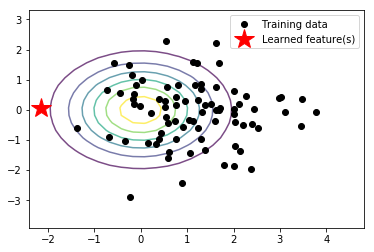

In [12]:
# xtr is an n x d numpy array
xtr = tr.data()

# training data
plt.plot(xtr[:, 0], xtr[:, 1], 'ko', label='Training data')

# feature
plt.plot(V_opt[:, 0], V_opt[:, 1], 'r*', label='Learned feature(s)', markersize=20)

max0, max1 = np.max(xtr, 0)
min0, min1 = np.min(xtr, 0)

sd0, sd1 = ((max0-min0)*0.4, (max1-min1)*0.4)
# form a test location grid to try 
nd0 = 30
nd1 = 30
loc0_cands = np.linspace(min0-sd0/2, max0+sd0/2, nd0)
loc1_cands = np.linspace(min1-sd1/2, max1+sd1/2, nd1)
lloc0, lloc1 = np.meshgrid(loc0_cands, loc1_cands)
# nd1 x nd0 x 2
loc3d = np.dstack((lloc0, lloc1))
# #candidates x 2
all_loc2s = np.reshape(loc3d, (-1, 2) )

den_grid = np.exp(p.log_den(all_loc2s))
den_grid = np.reshape(den_grid, (nd1, nd0))

# plt.figure(figsize=(10, 6))
# Plot the unnormalized density
CS = plt.contour(lloc0, lloc1, den_grid, alpha=0.7)
plt.legend(numpoints=1, loc='best')

Here, the learned feature(s) indicate that the data do not match the tail profile of $p$. If you would like to see the optimization surface, see the notebook `fssd_locs_surface.ipynb`.


##### Exercise 
Go back to where we sample the data from $q$, and change `m` (mean of the first coordinate of $q$) to 0. This will make $p=q$ so that $H_0$ is now true. Run the whole procedure again and verify that the test will not reject $H_0$. (Technically, the probability of rejecting is about $\alpha$.) 

Note that when the test fails to reject, the learned features are not interpretable. They will be arbitrary.

## Important note

A few points worth mentioning

* The FSSD test requires that the derivative of $\log p$ exists. 
* The test requires a technical condition called the "vanishing boundary" condition for it to be consistent. The condition is $\lim_{\|\mathbf{x} \|\to \infty} p(\mathbf{x}) \mathbf{g}(\mathbf{x}) = \mathbf{0}$ where $\mathbf{g}$ is the so called the `Stein witness function` (see the paper) which depends on the kernel and $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. For a density $p$ which has support everywhere e.g., Gaussian, there is no problem at all. However, for a density defined on a domain with a boundary, one has to be careful. For example, if $p$ is a Gamma density defined on the positive orthant of $\mathbb{R}$, the density itself can actually be evaluated on negative points. Looking at the way the Gamma density is written, there is nothing that tells the test that it cannot be evaluated on negative orthant. Therefore, if $p$ is Gamma, and the observed sample also follows $p$ (i.e., $H_0$ is true), the test will still reject $H_0$! The reason is that the data do not match the left tail (in the negative region!) of the Gamma. It is necessary to include the fact that negative region has 0 density into the density itself.


-----------------------

## Specify $p$ directly with its gradient

As mentioned, the FSSD test requires only $\nabla_{\mathbf{x}} \log p(\mathbf{x})$, and not even $\log p(\mathbf{x})$. If your model is such that it is easier to specify with its gradient, then this can be done as well. For instance, $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ when $p(\mathbf{x}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$ is given by $-\mathbf{x}$.

In [13]:
def isogauss_grad_log(X):
    """
    Evaluate the gradient of the log density of N(0, I) at the points (rows) in X.
    
    X: n x d nd-array
    Return an n x d numpy array of gradients
    """
    return -X

The `UnnormalizedDensity` can then be constructed with the following code. This defines the same model as before, and therefore will give the same test result.

In [14]:
p1 = density.from_grad_log(d, isogauss_grad_log)